# Load Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns
import math
import regex as re
%matplotlib inline

# Load Dataset

In [2]:
df = pd.read_excel('sales.xlsx')

# Analyze Dataset

In [3]:
df.head()

,ID,Prod,Quant,Val,Insp
0,v1,p1,182.0,1665.0,unkn
1,v2,p1,3072.0,8780.0,unkn
2,v3,p1,20393.0,76990.0,unkn
3,v4,p1,112.0,1100.0,unkn
4,v3,p1,6164.0,20260.0,unkn




As we can see, the dataset has 5 columns:

<ul>
    <li> <b>ID</b> – a factor with the ID of the salesman. </li>
    <li> <b>Prod</b> – a factor indicating the ID of the sold product. </li>
    <li> <b>Quant</b> – the number of reported sold units of the product. </li>
    <li> <b>Val</b> – the reported total monetary value of the sale. </li>
    <li> <b>Insp</b> – a factor with three possible values: ok if the transaction was </li>
inspected and considered valid by the company, fraud if the transaction
was found to be fraudulent, and unkn if the transaction was not inspected </li>
    </ul>


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401146 entries, 0 to 401145
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      401146 non-null  object 
 1   Prod    401146 non-null  object 
 2   Quant   387304 non-null  float64
 3   Val     399964 non-null  float64
 4   Insp    401146 non-null  object 
dtypes: float64(2), object(3)
memory usage: 15.3+ MB



We can see that 'ID' and 'Prod' columns are object type which will not help us order our results by ID or Product number. Also, 'Insp' columns is object type which is something weird as we know that this is our target column and should be category type.


In [5]:
df.ID = df.ID.str[1:].astype('int')
df.Prod = df.Prod.str[1:].astype('int')
df.Insp = df.Insp.astype('category')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401146 entries, 0 to 401145
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   ID      401146 non-null  int32   
 1   Prod    401146 non-null  int32   
 2   Quant   387304 non-null  float64 
 3   Val     399964 non-null  float64 
 4   Insp    401146 non-null  category
dtypes: category(1), float64(2), int32(2)
memory usage: 9.6 MB



We can now see that all columns are the desired dtype. We can continue with our analysis.


In [7]:
df.describe()

,ID,Prod,Quant,Val
count,401146.000000,401146.000000,3.873040e+05,3.999640e+05
mean,1882.266806,2180.357137,8.441996e+03,1.461707e+04
std,1598.946302,1113.129835,9.183510e+05,6.971259e+04
min,1.000000,1.000000,1.000000e+02,1.005000e+03
25%,589.000000,1274.000000,1.070000e+02,1.345000e+03
50%,1303.000000,2049.000000,1.680000e+02,2.675000e+03
75%,2930.000000,3098.000000,7.380000e+02,8.680000e+03
max,6070.000000,4548.000000,4.738839e+08,4.642955e+06


Check how many rows have the Product Quantity or the Product Value missing:
    

In [8]:
print('Quant NA rows:', df.Quant.isna().sum())
print('Val NA rows:', df.Val.isna().sum())

Quant NA rows: 13842
Val NA rows: 1182



We can also check which salesperson or product has the most appereances in our dataset:


In [9]:
df.ID.value_counts().head()

431     10159
54       6017
426      3902
1679     3016
1085     3001
Name: ID, dtype: int64

In [10]:
df.Prod.value_counts().head()

1125    3923
3774    1824
1437    1720
1917    1702
4089    1598
Name: Prod, dtype: int64

Something that is of major importance is how many transactions are categorized as 'ok', 'fraud' and 'unkn':
    

In [11]:
df.Insp.value_counts()

unkn     385414
ok        14462
fraud      1270
Name: Insp, dtype: int64

In [12]:
(df.Insp.value_counts()/df.shape[0] * 100)

unkn     96.078236
ok        3.605171
fraud     0.316593
Name: Insp, dtype: float64

We can observe that most of the transactions are labeled as 'Unknown' which is something that may struggle us. Another important mention here is that we have a strong imbalance between fraud and non-fraud transactions. This is something we should care about because some particular machine learning algorithms may not work well on such cases.


In [14]:
print('Quant and Val NA rows:', (df.Quant.isna() & df.Val.isna()).sum())

Quant and Val NA rows: 888



plot of a barplot that shows the number of reports per salesperson.


<BarContainer object of 6016 artists>

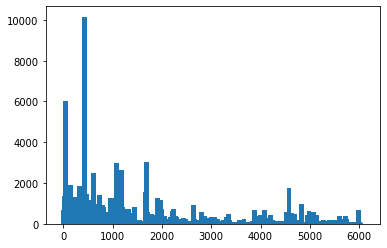

In [15]:
id_table = df.ID.value_counts()
plt.bar(x=id_table.index, height=id_table, width=100)


We can clearly observer that the numbers diverse across the salespeople. Let's do the same barplot for products.
    


<BarContainer object of 4548 artists>

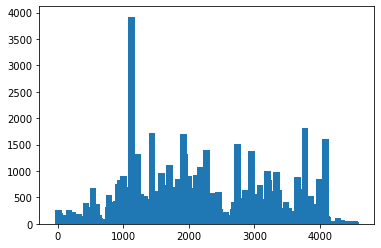

In [16]:
prod_table = df.Prod.value_counts()
plt.bar(x=prod_table.index, height=prod_table, width=100)

Again, we observe a strong variability.



Something that will help us with our analysis is to calculate a Unit Price for each product. We can then use this value by calculating a median typical price for each product. We can assume that a product price should follow a normal distribution, so abnormal prices will be easy to find.
    


In [17]:
df['UnitPrice'] = df.Val/df.Quant



The unit price should be relatively constant over the transactions of the
same product. When analyzing transactions over a short period of time, one
does not expect strong variations of the unit price of the products.
If we check the distribution of the unit price, for example,


In [18]:
df.UnitPrice.describe()

count    387010.000000
mean         20.297586
std         111.032561
min           0.000002
25%           8.460324
50%          11.886792
75%          19.112277
max       26460.700000
Name: UnitPrice, dtype: float64


we can again observe a rather marked variability.

In [19]:
print('Unit Price NA:', df.UnitPrice.isna().sum())

Unit Price NA: 14136



It may be interesting to check what the top most expensive and cheap
products are. We will group the rows by Product Number and calculate the median Unit Price for each one. We can then order the rows in ascending and descending order.


In [20]:
topP = pd.DataFrame({'Expensive':df.groupby('Prod').median().sort_values('UnitPrice', ascending=False).dropna().index, 
             'Cheap':df.groupby('Prod').median().sort_values('UnitPrice').dropna().index})
topP.head()

,Expensive,Cheap
0,3689,560
1,2453,559
2,2452,4195
3,2456,601
4,2459,563




We can confirm the completely different price distribution of the top products using a box plot of their unit prices:



In [21]:
tops = df.loc[df.Prod.isin(topP.iloc[0])]

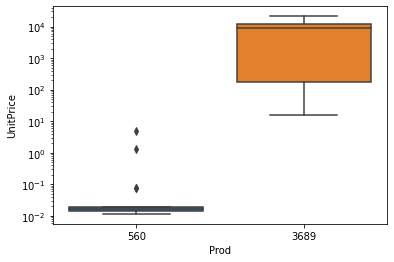

In [22]:
bx = sns.boxplot(y='UnitPrice', x='Prod', data=tops).set_yscale('log')


The scales of the prices of the most expensive and cheapest
products are rather different. Because of this, we have used a log scale in the
graph to avoid the values of the cheapest product becoming indistinguishable.
    
We can carry out a similar analysis to discover which salespeople are the
ones who bring more (less) money to the company,



In [23]:
scoresSs = pd.DataFrame({'Most':df.groupby('ID').sum().sort_values('Val', ascending=False).dropna().index, 
             'Least':df.groupby('ID').sum().sort_values('Val').dropna().index})
scoresSs.head()

,Most,Least
0,431,3355
1,54,6069
2,19,5876
3,4520,6058
4,955,4515


In [25]:
print(f'{sum(df.Val.dropna().loc[df.ID.isin(scoresSs.loc[0:99].Most)])/sum(df.Val.dropna()) * 100:.2f}%')
print(f'{sum(df.Val.dropna().loc[df.ID.isin(scoresSs.loc[0:1999].Least)])/sum(df.Val.dropna()) * 100:.2f}%')

38.33%
1.99%




It may be interesting to note that the top 100 salespeople on this list
account for almost 40% of the income of the company, while the bottom 2,000
out of the 6,016 salespeople generate less than 2% of the income.
    
Let's carry out a similar analysis in terms of the quantity that is sold for
each product:


In [27]:
scoresPs = pd.DataFrame({'Most':df.groupby('Prod').sum().sort_values('Quant', ascending=False).dropna().index, 
             'Least':df.groupby('Prod').sum().sort_values('Quant').dropna().index})
scoresPs.head()

,Most,Least
0,2516,2443
1,3599,2442
2,314,1653
3,569,4101
4,319,3678


In [28]:
print(f'{sum(df.Quant.dropna().loc[df.Prod.isin(scoresPs.loc[0:99].Most)])/sum(df.Quant.dropna()) * 100:.2f}%')
print(f'{sum(df.Quant.dropna().loc[df.Prod.isin(scoresPs.loc[0:3999].Least)])/sum(df.Quant.dropna()) * 100:.2f}%')

74.63%
8.94%




It is shown that the results are even more unbalanced. From the 4,548 products, 4,000 represent less than 10% of the sales volume,
with the top 100 representing nearly 75%.
    
  



One of the main assumptions we will be making in our analysis to find abnormal transaction reports is that the unit price of any product should follow
a near-normal distribution. This means that we expect that the transactions of
the same product will have roughly the same unit price with some small variability, possibly caused by some strategies of the salespeople to achieve their
commercial goals.

The following code
determines the number of outliers (according to the above definition) of each
product:    



In [29]:
stats = df.dropna().groupby('Prod').apply(lambda x: boxplot_stats(x.UnitPrice))
pattern = "array\((.*?)\)"

outliers = {}

for i in range(1,len(stats)):
    try:
        string = ""
        if (re.search(pattern, str(stats[i]), flags = re.DOTALL)):
            string = re.search(pattern, str(stats[i]), flags = re.DOTALL).group(1)
            outliers[i] = len(list(string.split(",")))
    except KeyError:
        continue
    
out = pd.DataFrame.from_dict(outliers, orient='index')
out.columns = ['Outliers']
out.sort_values('Outliers', ascending=False)[0:10]

,Outliers
1125,376
1437,181
2273,165
1918,156
1917,156
4089,137
538,129
3774,125
2742,120
3338,117


# Handle Unknown Data



As we mentioned earlier, we have 888 rows in our dataset with both Value and Quantity missing. Removing all 888 cases may be problematic if this leads to removing most transactions of some product or salesperson. Let us check this. The salespeople and products involved in the problematic transactions are the following:


In [30]:
totS = df.ID.value_counts()
totP = df.Prod.value_counts()

nas = df.loc[df.Quant.isna() & df.Val.isna()][['ID', 'Prod']]
nas

,ID,Prod
3227,29,808
4166,453,921
5102,431,1035
5211,431,1
5213,431,1
...,...,...
396552,4834,3801
396751,2719,3825
400010,1247,4088
400094,1085,4089




We now obtain the salespeople with a larger proportion of transactions
with unknowns on both Val and Quant:


In [31]:
propS = 100 * nas.ID.value_counts()/totS
propS.sort_values(ascending=False)[0:10]

1237    13.793103
4254     9.523810
4038     8.333333
5248     8.333333
3666     6.666667
4433     6.250000
4170     5.555556
4926     5.555556
4664     5.494505
4642     4.761905
Name: ID, dtype: float64



Ιt seems reasonable to delete these transactions, at least from the perspective of the salespeople, as they represent a small proportion of their transactions. Moreover, the alternative of trying to fill in both columns seems much more risky.
    
With respect to the products, these are the numbers:
    


In [32]:
propP = 100 * nas.Prod.value_counts()/totP
propP.sort_values(ascending=False)[0:10]

2689    39.285714
2675    35.416667
4061    25.000000
2780    22.727273
4351    18.181818
2686    16.666667
2707    14.285714
2690    14.084507
2691    12.903226
2670    12.765957
Name: Prod, dtype: float64



Here are several products that would have more than 20% of their transactions removed; and in particular, product p2689 would have almost 40% of them removed. This seems clearly too much. On the other hand, if we decide 176 Data Mining with R: Learning with Case Studies to fill in these unknown values, the only reasonable strategy is to use the information on the “complete” transactions of the same product. This would mean to fill in 40% of the transactions of a product using the information of the
remaining 60%. This also seems unreasonable.



In summary, the option of removing all transactions with unknown values on
both the quantity and the value is the best option we have:



In [33]:
df = df.dropna(subset=['Quant', 'Val'], how='all')


Let us now analyze the remaining reports with unknown values in either the
quantity or the value of the transaction. We start by calculating the proportion
of transactions of each product that have the quantity unknown:
    


In [34]:
nnasQp = df.groupby(df.Prod).apply(lambda x: sum(x.Quant.isna()))
propNAsQp = nnasQp/df.Prod.value_counts()
propNAsQp.sort_values(ascending=False)[0:10]

2443    1.000000
2442    1.000000
1653    0.909091
4101    0.857143
4243    0.684211
903     0.666667
3678    0.666667
3955    0.642857
4464    0.636364
1261    0.633333
dtype: float64


There are two products (p2442 and p2443) that have all their transactions
with unknown values of the quantity. Without further information it is virtually impossible to do anything with the transactions of these products because
we are unable to calculate their typical unit price.


In [35]:
df.loc[(df.Prod == 2442) | (df.Prod == 2443)].count()

ID           54
Prod         54
Quant         0
Val          54
Insp         54
UnitPrice     0
dtype: int64

In [36]:
df.loc[((df.Prod == 2442) | (df.Prod == 2443)) & (df.Insp == 'fraud')].count()

ID           2
Prod         2
Quant        0
Val          2
Insp         2
UnitPrice    0
dtype: int64

In [37]:
df.loc[((df.Prod == 2442) | (df.Prod == 2443)) & (df.Insp == 'ok')].count()

ID           1
Prod         1
Quant        0
Val          1
Insp         1
UnitPrice    0
dtype: int64



These are 54 reports, and two of them are tagged as frauds while another was found to be OK. This must mean that either the inspectors had more information than given in this dataset, or we are probably facing typing errors as it seems unfeasible to conclude anything on these transactions. In this context, we will delete them:
    


In [38]:
df = df[(df.Prod != 2442) & (df.Prod != 2443)]

In [39]:
df.Prod.nunique()

4546

In [40]:
nnasQs = df.groupby(df.ID).apply(lambda x: sum(x.Quant.isna()))
propNAsQs = nnasQs/df.ID.value_counts()
propNAsQs.sort_values(ascending=False)[0:10]

5537    1.000000
5836    1.000000
6065    1.000000
6058    1.000000
2925    1.000000
4368    0.888889
2923    0.875000
2970    0.857143
4910    0.833333
4542    0.809524
dtype: float64



As we can see, there are several salespeople who have not filled in the
information on the quantity in their reports. However, in this case the problem
is not so serious. In effect, as long as we have other transactions of the same
products reported by other salespeople, we can try to use this information
to fill in these unknowns using the assumption that the unit price should be
similar. Because of this, we will not delete these transactions.
We will now carry out a similar analysis for the transactions with an unknown value in the Val column. First, the proportion of transactions of each
product with unknown value in this column:
    

In [41]:
nnasVp = df.groupby(df.Prod).apply(lambda x: sum(x.Val.isna()))
propNAsVp = nnasVp/df.Prod.value_counts()
propNAsVp.sort_values(ascending=False)[0:10]

1110    0.250000
1022    0.176471
4491    0.100000
1462    0.075000
80      0.062500
4307    0.058824
4471    0.058824
2821    0.053892
4287    0.052632
1017    0.052632
dtype: float64


The numbers are reasonable so it does not make sense to delete these
transactions as we may try to fill in these holes using the other transactions.
With respect to salesperson, the numbers are as follows:



In [42]:
nnasVs = df.groupby(df.ID).apply(lambda x: sum(x.Val.isna()))
propNAsVs = nnasVs/df.ID.value_counts()
propNAsVs.sort_values(ascending=False)[0:10]

5647    0.375000
74      0.222222
5946    0.200000
5290    0.153846
4472    0.125000
4022    0.097561
975     0.095745
2814    0.090909
2892    0.090909
3739    0.083333
dtype: float64


Once again, the proportions are not too high.
    
At this stage we have removed all reports that had insufficient information
to be subject to a fill-in strategy. For the remaining unknown values, we will
apply a method based on the assumption that transactions of the same products should have a similar unit price. We will start by obtaining this typical
unit price for each product. We will skip the prices of transactions that were
found to be frauds in the calculation of the typical price. For the remaining
transactions we will use the median unit price of the transactions as the typical
price of the respective products:



In [43]:
tPrice = df[df.Insp != 'fraud'].groupby(df.Prod).median()['UnitPrice']
tPrice

Prod
1       11.428571
2       10.877863
3       10.000000
4        9.911243
5       11.000000
          ...    
4544     2.080603
4545     5.279853
4546    37.196328
4547     9.901961
4548     8.796992
Name: UnitPrice, Length: 4546, dtype: float64



Having a typical unit price for each product, we can use it to calculate any
of the two possibly missing values (Quant and Val). This is possible because
we currently have no transactions with both values missing. The following
code fills in all remaining unknown values:
    


In [44]:
df.Quant.isna().sum()

12900

In [45]:
tPrices = tPrice[df[df.Quant.isna()].Prod]
tPrices.index = df[df.Quant.isna()].index
df.loc[df.Quant.isna(), 'Quant'] = np.ceil(df[df.Quant.isna()].Val/tPrices)

In [46]:
df.Quant.isna().sum()

0

In [47]:
df.Val.isna().sum()

294

In [48]:
tPrices2 = tPrice[df[df.Val.isna()].Prod]
tPrices2.index = df[df.Val.isna()].index
df.loc[df.Val.isna(), 'Val'] = np.ceil(df[df.Val.isna()].Quant * tPrices2)

In [49]:
df.Val.isna().sum()

0



We have just filled in 12,900 unknown quantity values plus 294 total values of transaction. Given that we now have all Quant and Val values, we can recalculate the UnitPrice column to fill in the previously unknown unit prices:
    


In [50]:
df.UnitPrice = df.Val/df.Quant 



After all these pre-processing steps, we have a dataset free of unknown
values. For future analysis, it makes sense that you save this current state of
the sales data frame so that you can restart your analysis from this point,
without having to repeat all the steps. We can save the data frame as follows:


In [51]:
df.to_excel('salesClean.xlsx')


For each product we can also find the median and IQR of the Unit Price.



In [52]:
stats2 = df[df.Insp != 'fraud'].dropna().groupby('Prod').apply(lambda x: boxplot_stats(x.UnitPrice))
pattern2 = "'med': ([0-9.]*)"
pattern3 = "'iqr': ([0-9.]*)"

medians = []
iqrs = []

for i in range(1,len(stats2)):
    try:
        string = ""
        if (re.search(pattern2, str(stats2[i]), flags = re.DOTALL)):
            string = re.search(pattern2, str(stats2[i]), flags = re.DOTALL).group(1)
            medians.append(string)
        if (re.search(pattern3, str(stats2[i]), flags = re.DOTALL)):
            string = re.search(pattern3, str(stats2[i]), flags = re.DOTALL).group(1)
            iqrs.append(string)
    except KeyError:
        continue
    
med_iqr = pd.DataFrame({'medians': medians, 'iqrs': iqrs})
med_iqr.index = med_iqr.index + 1
med_iqr.sort_index().head()

,medians,iqrs
1,11.346153846153847,8.56357993548007
2,10.877862595419847,5.6097314758732075
3,10.0,4.809091958714168
4,9.911242603550296,5.998529666817149
5,10.957446808510639,7.136600902415289


<div class="alert alert-block alert-info"> 
    <b><h1> Anomaly Detection Algorithms - Unsupervised </h1></b> 
</div>

## 1. Isolation Forest Algorithm

In [62]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

rng = np.random.RandomState(42)

le = preprocessing.LabelEncoder()

X = df.drop('Insp', axis=1)
y = df.Insp

y = le.fit_transform(y)
# 0: fraud, 1: ok, 2: unkn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng)

clf = IsolationForest(n_estimators=100, max_samples='auto', random_state=rng, contamination=float(.12))
clf.fit(X_train)
y_pred_test = clf.predict(X_test)
# 1: ok, -1: fraud

### Model Evaluation

In [64]:
Tp = sum((y_test == 1) & (y_pred_test == 1))
Fp = sum((y_test == 0) & (y_pred_test == 1)) # predicted 'ok', but it was actually 'fraud'
Fn = sum((y_test == 1) & (y_pred_test == -1)) # predicted 'fraud', but it was actually 'ok' 

P = Tp/(Tp+Fp)
R = Tp/(Tp+Fn)

print(f'Precision: {P:.2f}')
print(f'Recall: {R:.2f}')

Precision: 0.94
Recall: 0.64



We can see that this algorithm can achieve very good precision score. Recall score, which is more important in our application, is also good but let's try another algorithm to see if we will have better results.


## 2. Local Outlier Factor

In [65]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

rng = np.random.RandomState(42)

le = preprocessing.LabelEncoder()

X = df.drop('Insp', axis=1)
y = df.Insp

y = le.fit_transform(y)
# 0: fraud, 1: ok, 2: unkn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng)

clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(X_train)
y_pred_test = clf.predict(X_test)
# 1: ok, -1: fraud

### Model Evaluation

In [66]:
Tp = sum((y_test == 1) & (y_pred_test == 1))
Fp = sum((y_test == 0) & (y_pred_test == 1)) # predicted 'ok', but it was actually 'fraud'
Fn = sum((y_test == 1) & (y_pred_test == -1)) # predicted 'fraud', but it was actually 'ok' 

P = Tp/(Tp+Fp)
R = Tp/(Tp+Fn)

print(f'Precision: {P:.2f}')
print(f'Recall: {R:.2f}')

Precision: 0.94
Recall: 0.92




We can observe that the second algorithm (LOF) has better results than the first one. It manages to achieve both great Precision and Recall scores.
